# Analysis of lift and drag for different mesh resolutions in the base flow configuration

The base flow configuration has been repeatedly run with varying mesh resolution; see the script *mesh_study* for details. The mesh was refined by increasing the resolution of the background mesh generated by *blockMesh*.

- $N_x$ - number of cells in x-direction (*blockMesh*); for the other directions, the numbers of cells is computed automatically 
- $\Delta_{bg}$ - representative cell-width of the background mesh
- $\Delta_{bl}$ - width of the cell layers aligned with the cylinder surface
- $\Delta_s$ - representative cell-width at the cylinder surface

The representative cell-sizes have been estimated using ParaView (cell-selection tool; *Extract Selection* filter; Information tab next to propeties; *Bounds*)


| cells  | $\Delta_{bg}$ | $\Delta_{bl}$ | $\Delta_s$ |
|--------:|:-------------:|:-------------:|:----------:|
| 50  | 4.35e-2  | 1.18e-2  | 1.592e-3 |
| 100 | 2.18e-2  | 0.592e-2 | 0.796e-3 |
| 200 | 1.09e-2  | 0.296e-2 | 0.398e-3 |
| 300 | 0.817e-2 | 0.198e-2 | 0.295e-3 |
| 400 | 0.544e-2 | 0.148e-2 | 0.199e-3 |

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import fftpack

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

data_path = "plot_data/cases/"
cases = ["case_{:1d}".format(i) for i in range(1, 6)]
cases

['case_1', 'case_2', 'case_3', 'case_4', 'case_5']

## Loading the data

In [2]:
coeff_data = {}

location_in_case = "/postProcessing/forces/0/coefficient.dat"
names = ["time", "c_d", "c_l"]

for case in cases:
    file_path = data_path + case + location_in_case
    coeff_data[case] = pd.read_csv(file_path, sep="\t", skiprows=range(13), usecols=[0, 1, 3], header=None, names=names)

## Drag and lift coefficients over time

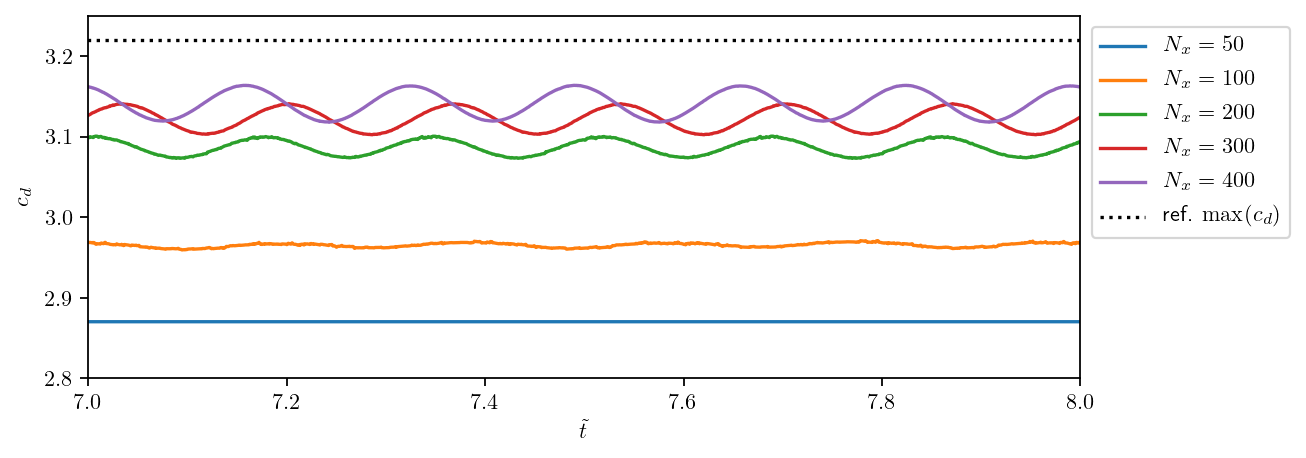

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

labels = [r"$N_x={:d}$".format(cells) for cells in [50, 100, 200, 300, 400]]

for i, case in enumerate(cases):
    data = coeff_data[case]
    ax.plot(data.time, data.c_d, label=labels[i])

# reference Schäfer et al.
ax.plot([0.0, 8.0], [3.22, 3.22], color="k", ls=":", label=r"ref. $\mathrm{max}(c_d)$")
    
ax.set_xlim(7, 8)
ax.set_ylim(2.8, 3.25)
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$c_d$")
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

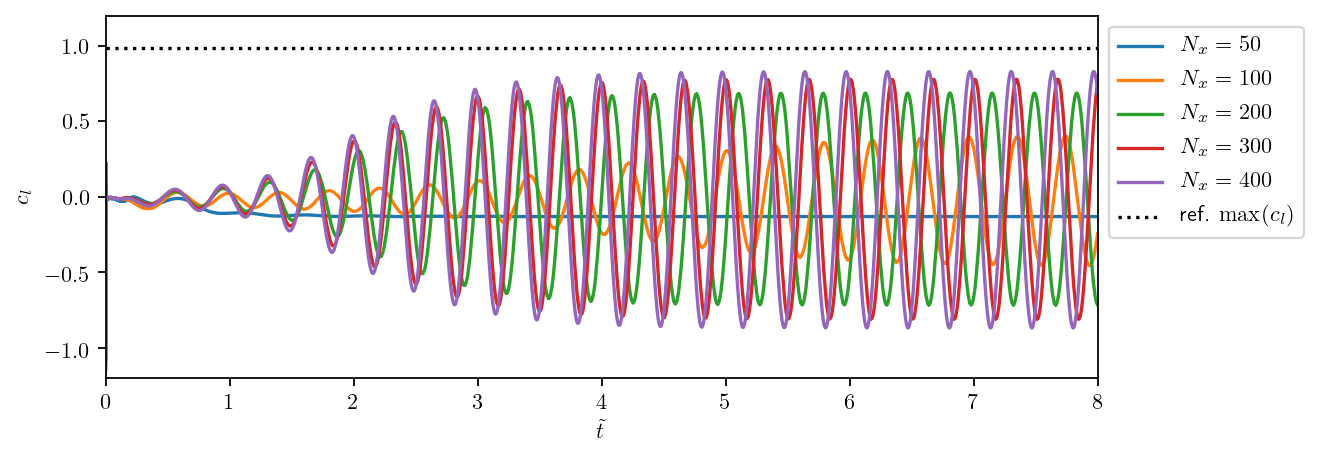

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

labels = [r"$N_x={:d}$".format(cells) for cells in [50, 100, 200, 300, 400]]

for i, case in enumerate(cases):
    data = coeff_data[case]
    ax.plot(data.time, data.c_l, label=labels[i])

# reference Schäfer et al.
ax.plot([0.0, 8.0], [0.99, 0.99], color="k", ls=":", label=r"ref. $\mathrm{max}(c_l)$")
    
ax.set_xlim(0, 8)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$c_l$")
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left')

## Statistics

In [5]:
win_start = 4

cd_zero_mean = {}
cl_zero_mean = {}

for case in cases:
    data = coeff_data[case]
    data = data[data.time >= win_start]
    cd_zero_mean[case] = data.c_d.values - data.c_d.mean()
    cl_zero_mean[case] = data.c_l.values - data.c_l.mean()
    print("mean drag/lift for {:s}: {:2.4f}/{:2.4f}".format(case, np.round(data.c_d.mean(), 4), np.round(data.c_l.mean(), 4)))

mean drag/lift for case_1: 2.8702/-0.1295
mean drag/lift for case_2: 2.9515/-0.0305
mean drag/lift for case_3: 3.0858/-0.0042
mean drag/lift for case_4: 3.1208/-0.0175
mean drag/lift for case_5: 3.1402/-0.0173


In [6]:
fft_cd = {}
fft_cl = {}

for case in cases:
    # drag
    data = cd_zero_mean[case]
    cd_fft = fftpack.fft(data)
    power = np.abs(cd_fft)
    time_step = (8.0 - 4.0) / data.shape[0]
    sample_freq = fftpack.fftfreq(data.shape[0], d=time_step)
    fft_cd[case] = (sample_freq, power)
    # lift
    data = cl_zero_mean[case]
    cl_fft = fftpack.fft(data)
    power = np.abs(cl_fft)
    time_step = (8.0 - 4.0) / data.shape[0]
    sample_freq = fftpack.fftfreq(data.shape[0], d=time_step)
    fft_cl[case] = (sample_freq, power)

Frequency peak at f=0.25
Frequency peak at f=0.25
Frequency peak at f=5.75
Frequency peak at f=6.00
Frequency peak at f=6.00


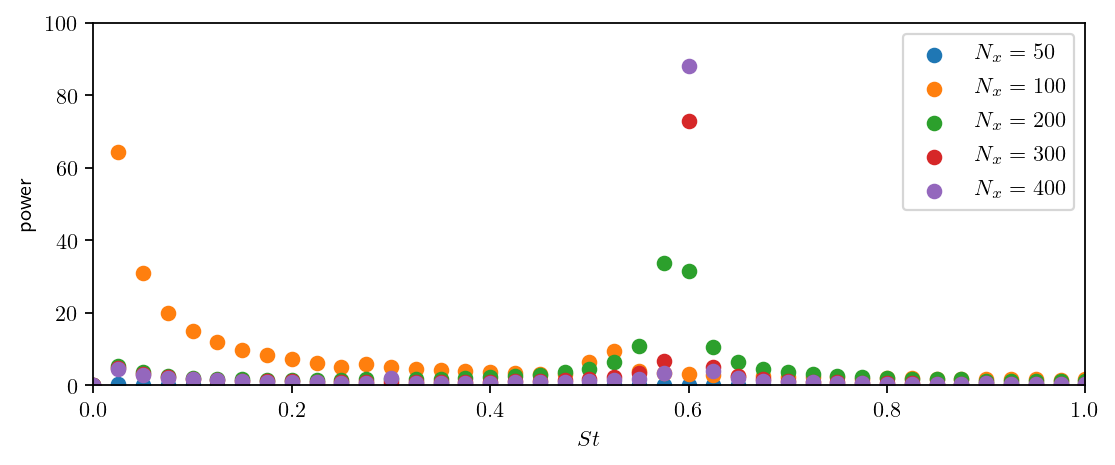

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

diameter = 0.1

for i, case in enumerate(cases):
    freq, power = fft_cd[case]
    ax.scatter(freq[:100]*diameter, power[:100], label=labels[i])
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))

ax.set_xlabel("$St$")
ax.set_ylabel("power")
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
ax.legend()

Frequency peak at f=2.00
Frequency peak at f=2.50
Frequency peak at f=3.00
Frequency peak at f=3.00
Frequency peak at f=3.00


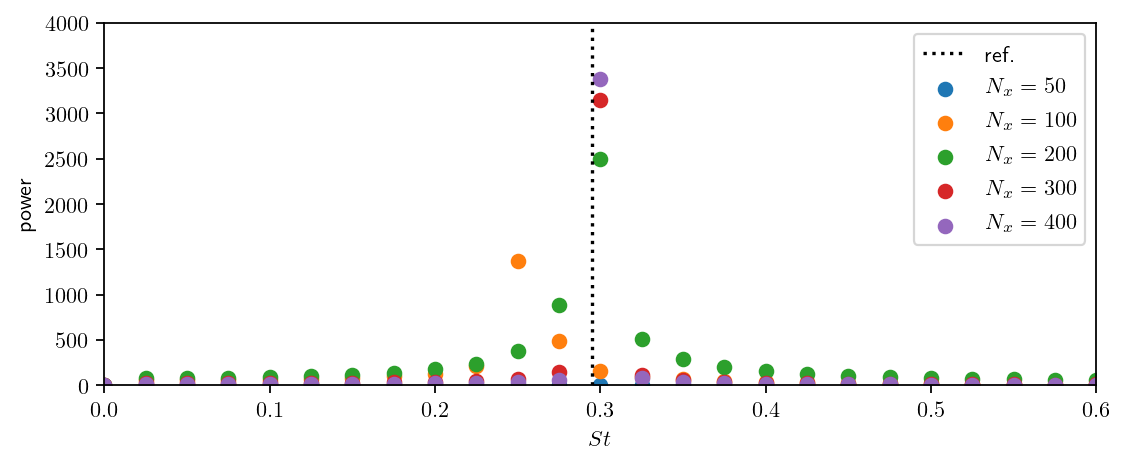

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

diameter = 0.1

for i, case in enumerate(cases):
    freq, power = fft_cl[case]
    ax.scatter(freq[:100]*diameter, power[:100], label=labels[i])
    print("Frequency peak at f={:2.2f}".format(freq[np.argmax(power)]))

ax.axvline(0.295, ls=":", color="k", label="ref.")
ax.set_xlabel("$St$")
ax.set_ylabel("power")
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 4000)
ax.legend()